# Traffic Light Classifier
**In this notebook, a deep learning approach is used for the purposes of detecting traffic lights and their corresponding state representation (i.e. Red, Green, Yellow).**

In [1]:
# Dependencies
# Load pickled data
import pickle
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

from math import *

%matplotlib inline
plt.style.use('ggplot')

*Define the training and test paths...*

In [2]:
import model.modelconfig as config

# Define training data paths
training_path = "./data2/train/images"
test_path = "./data2/test/images"

model_path = "./model/KaNet/"

if not os.path.exists(model_path):
    os.mkdir(model_path)

In [3]:
# Extract number of samples

def get_samples(path, patterns = ("*.png", "*.jpg")):
    paths = []
    for key in list(config.labels.keys()):
        dir = os.path.join(path, key)
        for pattern in patterns:
            paths += glob.glob(os.path.join(dir, pattern))
    return paths

train_samples = get_samples(training_path)
test_samples = get_samples(test_path)

print("Number of training samples: {}".format(len(train_samples)))
print("Number of test samples: {}".format(len(test_samples)))

Number of training samples: 853
Number of test samples: 349


In [4]:
# Uncomment to disable GPU acceleration
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import keras;
import tensorflow as tf
import keras.backend as K

# Check keras and tensorflow versions
print("Keras version: {}".format(keras.__version__))
print("TensorFlow version: {}".format(tf.__version__))
print("Channels: {}".format(K.image_data_format()))

# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Using CPU...')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Using TensorFlow backend.


Keras version: 2.0.8
TensorFlow version: 1.0.0
Channels: channels_last
No GPU found. Using CPU...


### SqueezeNet model

In [27]:
class_values = list(set(config.labels.values()))
class_labels = []
for i in class_values:
    for k,v in config.labels.items():
        if (v == i):
            class_labels.append(k)

print("Labels: {}".format(class_labels))
print("Values: {}".format(class_values))

Labels: ['red', 'off', 'green', 'yellow', 'unknown']
Values: [8, 1, 2, 4, 0]


In [7]:
# Model params
output_size = len(class_labels)
image_size = (None, None, 3)

dropout = 0.2
weight_decay = 1e-4

# Build model
from model.KaNet import KaNet

model = KaNet(output_size, image_size, dropout, weight_decay)

#### Define Optimiser for Training

In [8]:
# Optimiser params
optimiser = "Adam"
loss = "mean_squared_error"
metrics = ["mae", "acc"]

# Compile model
model.compile(optimiser, loss, metrics=metrics, loss_weights=None, sample_weight_mode=None)

print("\n## Model ##")
print(model.summary())


## Model ##
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
normalizer_1 (Normalizer)        (None, None, None, 3) 0           input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 64 4864        normalizer_1[0][0]               
____________________________________________________________________________________________________
average_pooling2d_1 (AveragePool (None, None, None, 64 0           conv2d_1[0][0]                   
______________________________________________________________________________

In [9]:
# Train on Bosch dataset
### Training parameters ###
noise = 0.2
batch_size = 32
max_epochs = 60

epoch_train_samples = int(floor(len(train_samples) / batch_size))
epoch_test_samples = int(floor(len(test_samples) / batch_size))

print("Steps per epoch (train): {}".format(epoch_train_samples))
print("Steps per epoch (test): {}".format(epoch_test_samples))

Steps per epoch (train): 26
Steps per epoch (test): 10


### Training

*Define image data generators and create noise on training set.*

In [10]:
import data.helpers.generator as g

print("\nInitializing generators...")

# compile and train the model using the generator function
train_generator = g.generator(training_path, config.labels, batch_size = batch_size, noise = noise)
validation_generator = g.generator(test_path, config.labels, batch_size = batch_size, noise = 0)

print(" - Done.\n")


Initializing generators...
 - Done.



*Define callbacks for use during training.*

In [11]:
### Train ###
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# setup callbacks, save every checkpoint, check for overfitting and reduce learning rate as required
callbacks = [
    CSVLogger(model_path + "/training-loss.csv", separator=',', append = True),
    #EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 7),
    ModelCheckpoint(filepath = model_path + config.checkpoint_pattern.replace("*","{epoch:02d}-{val_loss:.2f}"), monitor='val_loss', save_best_only=False, save_weights_only=True, verbose=0),
]

#### Learning

In [12]:
print("\nTraining...")

epoch = 0
# Train the model using the supplied generator
history = model.fit_generator(train_generator, steps_per_epoch = epoch_train_samples, 
                              validation_data = validation_generator, validation_steps = epoch_test_samples,
                              epochs = max_epochs, callbacks = callbacks, initial_epoch = epoch)


Training...
Epoch 1/60
26/26 [==============================] - 111s - loss: 0.1931 - mean_absolute_error: 0.3413 - acc: 0.2668 - val_loss: 0.1799 - val_mean_absolute_error: 0.3472 - val_acc: 0.2844
Epoch 2/60
26/26 [==============================] - 104s - loss: 0.1634 - mean_absolute_error: 0.3028 - acc: 0.3115 - val_loss: 0.1717 - val_mean_absolute_error: 0.3102 - val_acc: 0.1924
Epoch 3/60
26/26 [==============================] - 102s - loss: 0.1584 - mean_absolute_error: 0.2972 - acc: 0.3433 - val_loss: 0.1577 - val_mean_absolute_error: 0.3059 - val_acc: 0.4196
Epoch 4/60
26/26 [==============================] - 103s - loss: 0.1356 - mean_absolute_error: 0.2628 - acc: 0.5129 - val_loss: 0.1532 - val_mean_absolute_error: 0.2561 - val_acc: 0.4164
Epoch 5/60
26/26 [==============================] - 102s - loss: 0.1173 - mean_absolute_error: 0.2243 - acc: 0.5893 - val_loss: 0.1269 - val_mean_absolute_error: 0.2198 - val_acc: 0.4353
Epoch 6/60
26/26 [==============================] - 

26/26 [==============================] - 138s - loss: 0.0357 - mean_absolute_error: 0.0630 - acc: 0.8930 - val_loss: 0.0460 - val_mean_absolute_error: 0.0668 - val_acc: 0.8707
Epoch 45/60
26/26 [==============================] - 129s - loss: 0.0431 - mean_absolute_error: 0.0738 - acc: 0.8707 - val_loss: 0.0439 - val_mean_absolute_error: 0.0616 - val_acc: 0.8812
Epoch 46/60
26/26 [==============================] - 144s - loss: 0.0385 - mean_absolute_error: 0.0676 - acc: 0.8827 - val_loss: 0.0418 - val_mean_absolute_error: 0.0570 - val_acc: 0.8864
Epoch 47/60
26/26 [==============================] - 139s - loss: 0.0358 - mean_absolute_error: 0.0666 - acc: 0.8906 - val_loss: 0.0426 - val_mean_absolute_error: 0.0596 - val_acc: 0.8864
Epoch 48/60
26/26 [==============================] - 138s - loss: 0.0398 - mean_absolute_error: 0.0703 - acc: 0.8749 - val_loss: 0.0526 - val_mean_absolute_error: 0.0770 - val_acc: 0.8391
Epoch 49/60
26/26 [==============================] - 137s - loss: 0.0438

In [13]:
print(history.history.keys())

dict_keys(['val_mean_absolute_error', 'val_loss', 'mean_absolute_error', 'val_acc', 'loss', 'acc'])


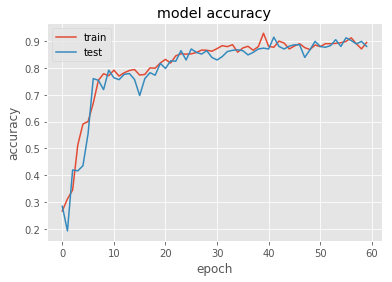

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


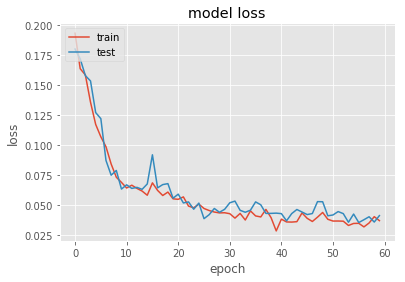

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
valid_path = "./data2/valid/images"

In [17]:
# load weights file from best run
#model.load_weights(model_path + "checkpoint-26-0.61.h5")

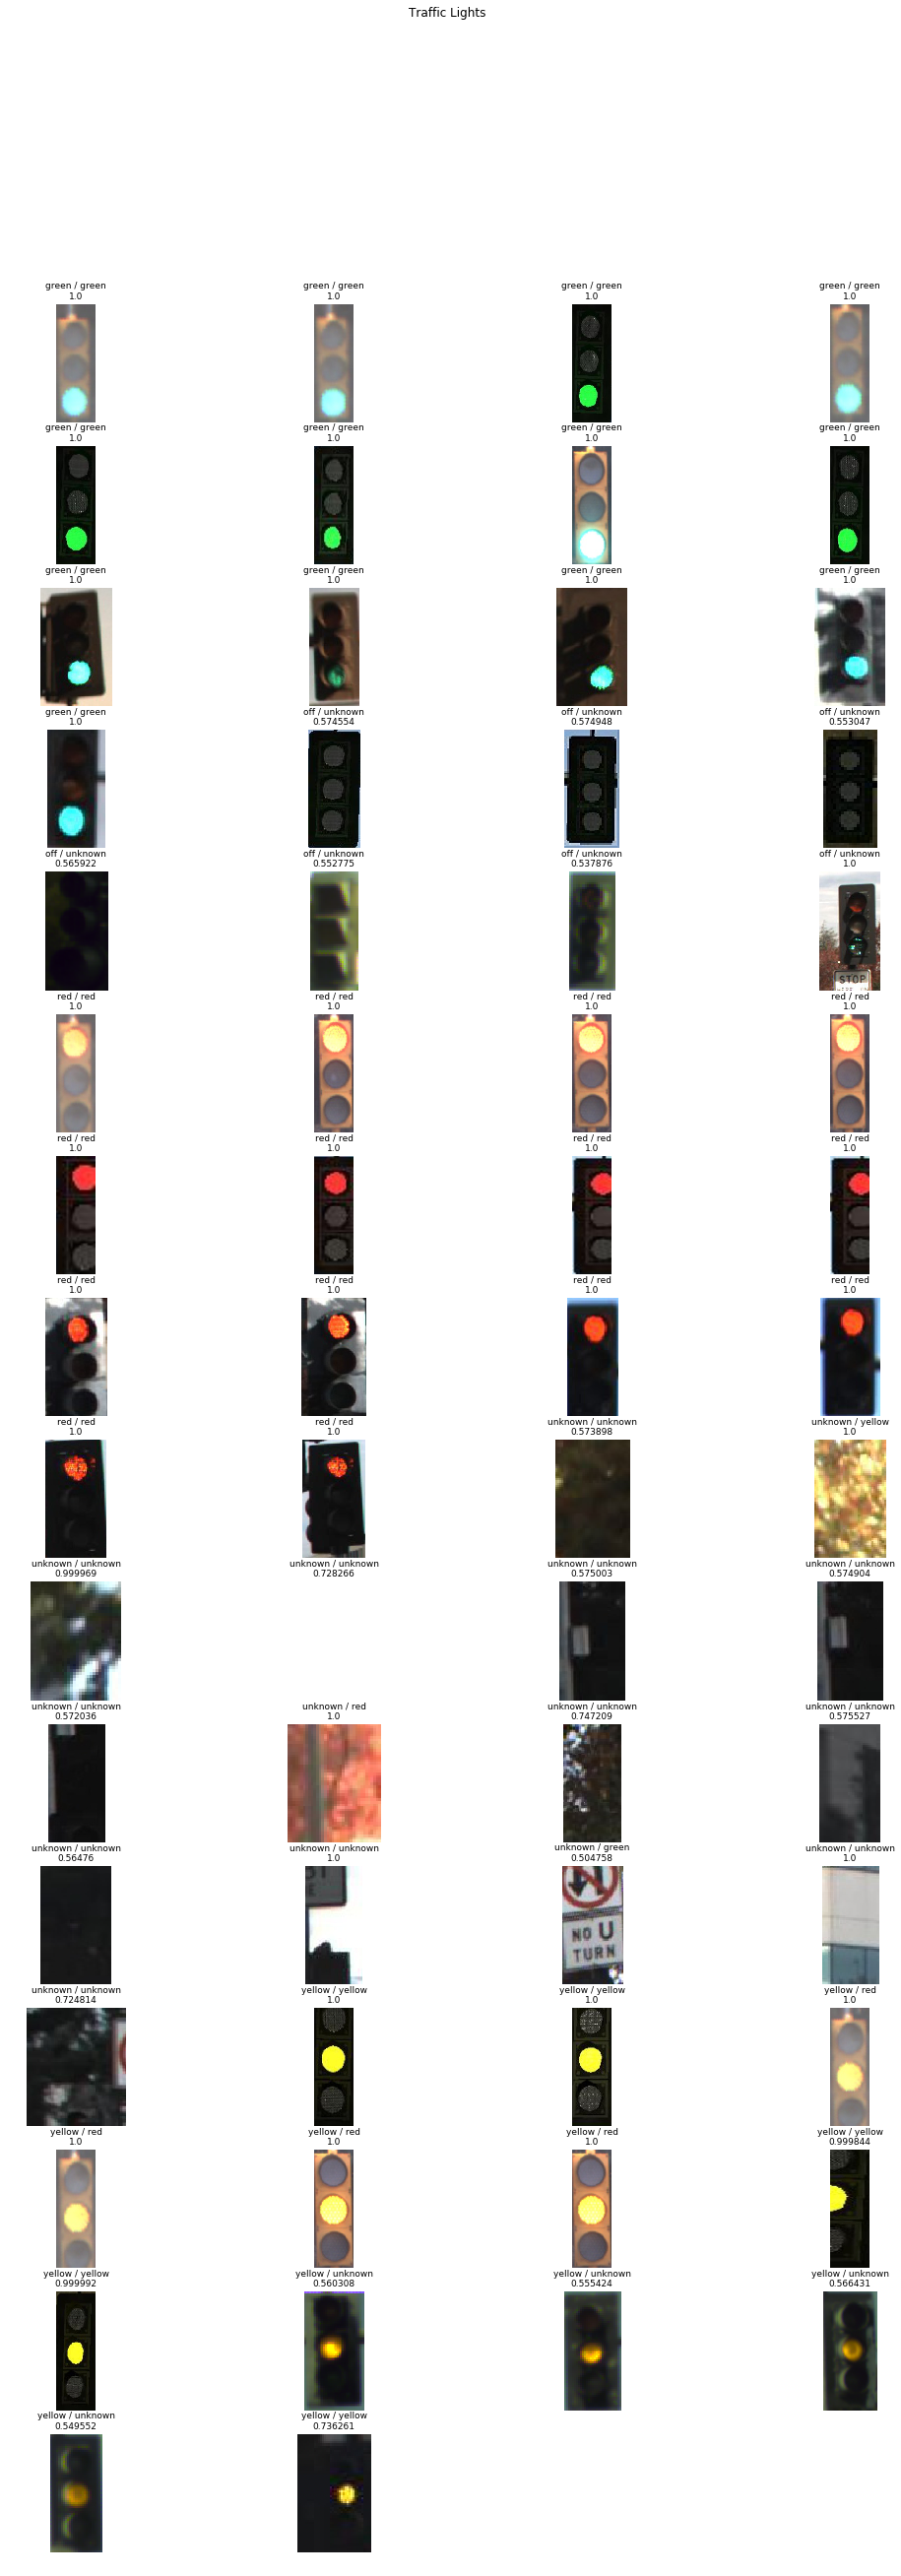

In [34]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

images = []
labels = []
labelnames = []

for dir in os.listdir(valid_path):
    sub_path = os.path.join(valid_path, dir)
    if (os.path.isdir(sub_path) and dir in config.labels):
        for img_name in os.listdir(sub_path):
            img_path = os.path.join(sub_path, img_name)
            images.append(img_path)
            labels.append(config.labels[dir])
            labelnames.append(dir)

num_rows = 16
num_cols = 4

fig = plt.figure(figsize=(18, 42))  # width, height in inches

k = 1

for i in range(len(labels)):
    image = mpimg.imread(images[i])
    label = labels[i]
    name = labelnames[i]
    
    image = np.asarray(image)
    
    pred = model.predict(image[None, :, :, 0:3], batch_size=1)[0]
    
    pred_idx = np.argmax(pred)
    pred_label = class_labels[pred_idx]
    pred_score = np.round(pred[pred_idx], 6)
    
    sub = fig.add_subplot(num_rows, num_cols, k)
    sub.set_title("{} / {}\n{}".format(name, pred_label, str(pred_score)), fontsize=9)
    sub.imshow(image)
    #sub.axis("off")
    
    color = "red"
    if (pred_label == label):
        color = "lime"
            
    #sub.set_label(str(pred_score))#, fontsize=8, color=color)
    sub.axis('off')
    
    k += 1

fig.suptitle("Traffic Lights",fontsize=12)


In [ ]:
# Write out model params to file for use in project